In [5]:
from pulearn import BaggingPuClassifier
from pulearn import WeightedElkanotoPuClassifier
from pulearn import ElkanotoPuClassifier
import pickle
import numpy as np
import pandas as pd
import numpy as np
# import parfit.parfit as pf
from sklearn.base import clone, is_classifier
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
# from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score,classification_report
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline
import warnings
from sklearn.model_selection import check_cv
from joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, ParameterGrid
from sklearn.utils.validation import _num_samples, indexable
from sklearn import metrics

def convert_to_lapsers_only(df):
    def helper(df):
        if df.Label.sum()==0:
            return pd.DataFrame([],columns=list(df.columns))
        return df
    return df.groupby('user',as_index=False).apply(helper)

data  = pickle.load(open('./data/parsed_data/with_non_lapsers_observation_60_prediction_60.p','rb'))
data_feature_label = convert_to_lapsers_only(data)

X = np.concatenate(list(data_feature_label['feature_final']))

y = data_feature_label['Label'].values
y = np.int64(np.array(y))
y[y>0] = 1
y[y<1] = -1

groups = data_feature_label['user'].values

X1 = np.float64(X[:,2:])

from sklearn import preprocessing
X_time = X[:,0].reshape(-1,1)
X_time = preprocessing.OneHotEncoder().fit_transform(X_time).todense()
X_gender = X[:,1].reshape(-1,1)
X_gender = preprocessing.OneHotEncoder().fit_transform(X_gender).todense()
X = np.concatenate([X_time,X_gender,X1],axis=1)

X.shape,y.shape,groups.shape

((21812, 92), (21812,), (21812,))

In [4]:
##please write participant specific normalization here

Fitting 53 folds for each of 6 candidates, totalling 318 fits


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of   6 | elapsed:   21.2s remaining:   10.6s
[Parallel(n_jobs=40)]: Done   6 out of   6 | elapsed:   23.2s finished


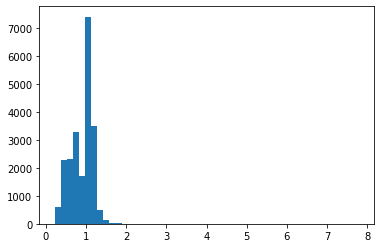

0.751065124771759 0.10861719919021214
0.18978775761304215 1.0124186191282007


In [4]:
def cv_fit_and_score(estimator, X, y, scorer, parameters, cv,parameters_pulearn):
    if str(estimator)[0] != 'B':
        temp = estimator.estimator
        estimator.set_params(**parameters_pulearn)
        estimator.set_params(**{'estimator__'+key:parameters[key] for key in parameters.keys()})
        parameters_pulearn.update({'estimator__'+key:parameters[key] for key in parameters.keys()})
        final_params = parameters_pulearn
    else:
        temp = estimator.base_estimator
        parameters_pulearn = {'n_estimators':parameters_pulearn['n_estimators']}
        estimator.set_params(**parameters_pulearn)
        estimator.set_params(**{'base_estimator__'+key:parameters[key] for key in parameters.keys()})
        parameters_pulearn.update({'base_estimator__'+key:parameters[key] for key in parameters.keys()})
        final_params = parameters_pulearn
    
    cv_probs_ = cross_val_probs(estimator, X, y, cv)
    score = scorer(cv_probs_, y)
    return [score, final_params]
   
def cross_val_probs(estimator, X, y, cv):
    probs = np.zeros(len(y))
    for train, test in cv:
#         print(np.unique(y[train]))
        temp = estimator.fit(X[train], y[train]).predict_proba(X[test]).reshape(len(test),-1)
        if temp.shape[1]==1:
            temp = temp[:,0]
        else:
            temp = temp[:,1]        
        probs[test] = temp
    return probs

def f1Bias_scorer_CV(probs, y, ret_bias=False):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1,bias = 0.0,.5
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and recall[i]>min_recall:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

class ModifiedGridSearchCV(GridSearchCV):
    def __init__(self, estimator, param_grid, scoring=None, fit_params=None,
                 n_jobs=1, iid=True, refit=True, cv=None, verbose=0,
                 pre_dispatch='2*n_jobs', error_score='raise',param_grid_pulearn = None):

        super(ModifiedGridSearchCV, self).__init__(
                estimator=estimator, param_grid=param_grid, scoring=scoring,  n_jobs=n_jobs, 
                refit=refit, cv=cv, verbose=verbose, pre_dispatch=pre_dispatch, error_score=error_score)
        self.parameter_iterable_pulearn = ParameterGrid(param_grid_pulearn)
    def fit(self, X, y):
        """Actual fitting,  performing the search over parameters."""

        parameter_iterable = ParameterGrid(self.param_grid)
        parameter_iterable_pulearn = self.parameter_iterable_pulearn

        estimator = self.estimator
        cv = self.cv

        n_samples = _num_samples(X)
        X, y = indexable(X, y)

        if y is not None:
            if len(y) != n_samples:
                raise ValueError('Target variable (y) has a different number '
                                 'of samples (%i) than data (X: %i samples)'
                                 % (len(y), n_samples))
        if self.verbose > 0:
            n_candidates = len(parameter_iterable)*len(parameter_iterable_pulearn)
            print("Fitting {0} folds for each of {1} candidates, totalling"
                  " {2} fits".format(len(cv), n_candidates,
                                     n_candidates * len(cv)))

        base_estimator = clone(self.estimator)

        pre_dispatch = self.pre_dispatch

        out = Parallel(
                n_jobs=self.n_jobs, verbose=self.verbose,
                pre_dispatch=pre_dispatch
        )(
                delayed(cv_fit_and_score)(clone(base_estimator), X, y, self.scoring,
                                          parameters, cv=cv, parameters_pulearn=params_pulearn)
                for parameters in parameter_iterable for params_pulearn in parameter_iterable_pulearn)
#         out = [cv_fit_and_score(clone(base_estimator), X, y, self.scoring,
#                                           parameters, cv=cv, parameters_pulearn=params_pulearn)
#                 for parameters in parameter_iterable for params_pulearn in parameter_iterable_pulearn]
        best = sorted(out,key=lambda x: x[0], reverse=True)[0]
        self.best_params_ = best[1]
        self.best_score_ = best[0]
#         print(best[1])
        if self.refit:
            best_estimator = clone(base_estimator).set_params(
                    **best[1])
            self.best_estimator_ = best_estimator

        return None
X1 = X.copy()
y = y.copy()
y[y==-1] = 0
groups = groups.copy()
gkf = GroupKFold(n_splits=len(np.unique(groups)))
delta = 0.2

# parameters = {'rf__kernel': ['rbf'],
#               'rf__C': [10],
#               'rf__gamma': np.logspace(-3,3,10),
#               'rf__class_weight': [{0: w, 1: 1 - w} for w in np.arange(0.0, .50, delta)],
#               'rf__probability':[True],
#               'rf__verbose':[False],
#               'rf__cache_size':[2000]}
# parameters = {
#     'rf__min_samples_leaf': [4],
#     'rf__max_features': [3,5,10],
#     'rf__n_estimators': [30,100,200],
#     'rf__n_jobs': [-1],
#     'rf__criterion':['gini','entropy'],
#     'rf__class_weight': [{0: w, 1: 1 - w} for w in np.arange(0.01, .6, delta)],
#     'rf__random_state': [42]
#        }
parameters = {
    'pca__n_components':[2,3],
    'rf__C':np.logspace(-3,3,1),
    'rf__n_jobs': [-1],
    'rf__class_weight': [{0: w, 1: 1 - w} for w in np.arange(0.01, .6, delta)],
}

## Pay close attention to the fields you populate here, only include 'labeled' and 'unlabeled' when using weighted PU learn
## when using bagging classifier it just only have one field 'n_estimators'
parameters_pulearn_weighted = {'hold_out_ratio':[.1],'labeled':[10],'unlabeled':[20]}
parameters_pulearn_simple = {'hold_out_ratio':[.1]}
parameters_pulearn_bagging = {'n_estimators':[2]}
# svc = Pipeline([('pca',PCA(n_components=10)),('rf',RandomForestClassifier())])
svc = Pipeline([('pca',PCA(n_components=10)),('rf',LogisticRegression())])
# svc = Pipeline([('sts',preprocessing.StandardScaler()),('pca',PCA(n_components=10)),('rf',SVC())])
# svc = RandomForestClassifier()
# grid_search = GridSearchCV(svc,parameters, cv=gkf.split(X1,y,groups=groups),
#              n_jobs=-1, scoring='f1', verbose=1, iid=False)
# clf = Pipeline([('sts',StandardScaler()),('clf',svc)])
min_recall = .6
pu_estimator = WeightedElkanotoPuClassifier(estimator=svc,labeled=10,unlabeled=20)
pu_estimator = BaggingPuClassifier(base_estimator=svc)
pu_estimator = ElkanotoPuClassifier(estimator=svc)
grid_search = ModifiedGridSearchCV(pu_estimator, parameters, cv=list(gkf.split(X1,y,groups=groups)),
                                   n_jobs=40, scoring=f1Bias_scorer_CV, verbose=1, iid=False,
                                   param_grid_pulearn=parameters_pulearn_simple)
grid_search.fit(X1,y)
clf = grid_search.best_estimator_
m = len(np.where(y==-1)[0])
n = len(np.where(y>0)[0])
CV_probs = cross_val_probs(clf, X1, y, gkf.split(X1,y,groups=groups))
import matplotlib.pyplot as plt
plt.hist(CV_probs,50)
plt.show()
score, bias = f1Bias_scorer_CV(CV_probs, y, True)
predicted = np.asarray(CV_probs >= bias, dtype=np.int)
print(recall_score(y,predicted), precision_score(y,predicted))
print(score,bias)

In [6]:
clf

ElkanotoPuClassifier(estimator=Pipeline(steps=[('pca', PCA(n_components=2)),
                                               ('rf',
                                                LogisticRegression(C=0.001,
                                                                   class_weight={0: 0.41000000000000003,
                                                                                 1: 0.59},
                                                                   n_jobs=-1))]))